# Simulation of model

In [384]:
import numpy as np
import pandas as pd
from sympy import symbols, solve
from scipy.optimize import fmin
import math
import matplotlib.pyplot as plt
import seaborn as sns

draw n random values for sigma

count    10000.000000
mean         4.524875
std          5.713793
min          0.085958
25%          1.421507
50%          2.776220
75%          5.434222
max        127.124149
dtype: float64


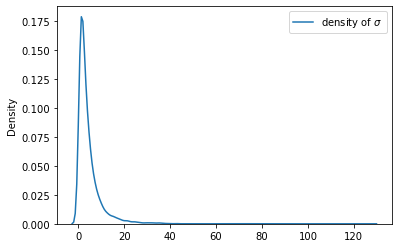

In [385]:
# number of random sigmas
np.random.seed(111)
n = 10000
# mean and sd of normal distribution 
m, s = 1,1
sigma = np.random.lognormal(mean=m, sigma=s, size=n) # takes values for normal distribution as inputs
# make to list
sigma = sigma.tolist()
#
print(pd.Series(sigma).describe())
# distribution
sns.kdeplot(sigma, label=r'density of $\sigma$')
plt.legend()


define values for $\pi$ and $\phi$

In [386]:
pi = 5
phi = 0.5
alpha = 0.5

## Cost functions
fixing cost function $C(x,\sigma) = \frac{\sigma}{\alpha} (\frac{x}{\sigma})^{-\alpha}$

Text(0, 0.5, 'C(x)')

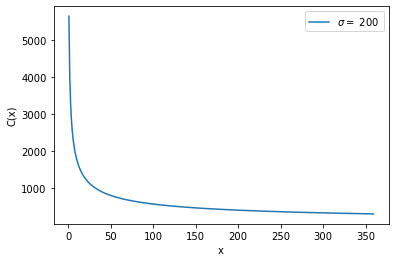

In [387]:
def C(x, sigma, alpha):
    first = sigma / alpha
    second = x / sigma
    power = -alpha
    return  first * (second**power)


# plot for fixed sigma
sigma_fix = 200
x = np.arange(1,360,1)  
plt.plot(x,C(x,sigma_fix, alpha), label = f'$\sigma = $ {sigma_fix}')
plt.legend()
plt.xlabel('x')
plt.ylabel('C(x)')

Cost function $K(x,\sigma) = (\pi + \phi)x + C(x, \sigma)$ with x, $\sigma$, $\pi$ and $\phi$ as inputs, $\phi = 50$ Rs if $x > 60$

Text(0, 0.5, 'K(x)')

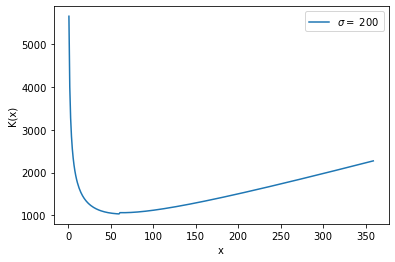

In [388]:
def K(x,sigma, pi, phi, alpha, type='scalar'):
    if x <= 60:
        exp =  (pi) * x + C(x, sigma, alpha)
    elif x > 60:  
        exp = (pi + phi) * x + C(x, sigma, alpha)  
    if type == 'scalar':
        return exp
    elif type == 'math_exp':
        return math.exp(exp)


# plot K with fixed sigma 
x = np.arange(1,360,1)
Ks = [K(x,sigma = sigma_fix, pi = pi, phi = phi, alpha = alpha, type = 'scalar') for x in x]  
plt.plot(x,Ks, label = f'$\sigma = $ {sigma_fix}')
plt.legend()
plt.xlabel('x')
plt.ylabel('K(x)')  

optimal x as a function of $\sigma$ : $x = \sigma (\pi + \phi)^{-1/(1+\alpha)}$

count    10000.000000
mean         1.547485
std          1.954090
min          0.029397
25%          0.486149
50%          0.949454
75%          1.858478
max         43.475847
dtype: float64

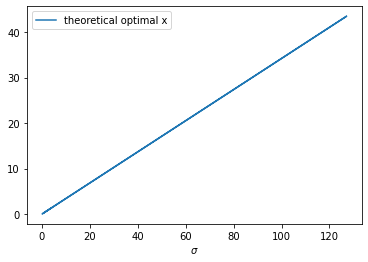

In [389]:
# optimal theoretical x
def xopt(sigma, pi, phi, alpha):
    return sigma * (pi + phi)**(-1/(1+alpha))


xopts = [xopt(s, pi=pi, phi=0, alpha=alpha) for s in sigma]
plt.plot(sigma, xopts, label ='theoretical optimal x')
plt.xlabel(r'$\sigma$')
plt.legend()

pd.Series(xopts).describe()

find the minimum x of K() for all sigmas

In [390]:
xstar = {}
for s in sigma:
    #if s < 150:
    x_start = xopt(s, pi=pi, phi=phi, alpha=alpha)
    x = fmin(K,x0 = x_start, args=(s,pi, phi, alpha, 'math_exp'), disp=True) 
    #else: x[0] = np.nan    
    if x < 0:
        raise ValueError('x negative')
    xstar[s] = x[0] # output of fmin is a list, access first element

Optimization terminated successfully.
         Current function value: 88.881970
         Iterations: 9
         Function evaluations: 18
Optimization terminated successfully.
         Current function value: 783452888.903029
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 1116853407354565459798130688.000000
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 17568.076524
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 569.243406
         Iterations: 9
         Function evaluations: 18
Optimization terminated successfully.
         Current function value: 6687.076442
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 510650.463767
         Iterations: 14
         Function ev

now put all all in a dataframe and calculate the costs for the optimal x's

In [399]:
df = pd.DataFrame.from_dict(xstar, orient='index', columns=['xstar'])
df = df.reset_index()
df = df.rename(columns={'index':'sigma'})


# calculate fixing cost C
df['fixing_cost'] = df.apply(lambda row: C(row.sigma,row.xstar, alpha=alpha), axis=1)
# calculate cost K
df['K'] = df.apply(lambda row: K(row.xstar, row.sigma, pi = pi, phi = phi, alpha=alpha), axis=1)

print(df.xstar.describe())
df.head()

count    10000.000000
mean         1.547490
std          1.954087
min          0.029398
25%          0.486159
50%          0.949452
75%          1.858478
max         43.475846
Name: xstar, dtype: float64


,sigma,xstar,fixing_cost,K
0,0.874731,0.299160,0.349904,4.487309
1,3.992107,1.365282,1.596843,20.479221
2,12.140583,4.152021,4.856233,62.280313
3,1.905259,0.651603,0.762128,9.773839
4,1.236725,0.422963,0.494706,6.344308


## Plots
compare the theoretical x and the x calculated from minimization and their density

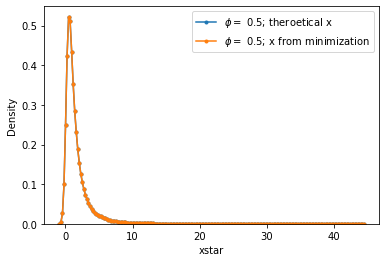

In [402]:
fig, ax = plt.subplots()
sns.kdeplot(df.xstar, marker='o', markersize=3, label = f'$\phi =$ {phi}; theroetical x', ax=ax) 
sns.kdeplot(xopts, marker='o', markersize=3, label = f'$\phi =$ {phi}; x from minimization', ax=ax) 
plt.legend()
#plt.xlim(-10,100)

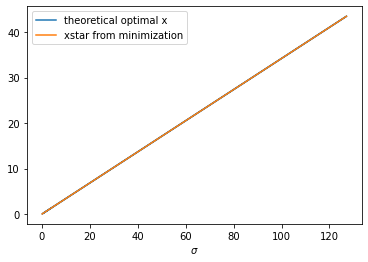

In [393]:
df_order = df.sort_values('sigma')

plt.plot(sigma, xopts, label='theoretical optimal x')
plt.plot(df_order.sigma, df_order.xstar, label='xstar from minimization' )
#plt.xlim(0,200)
plt.xlabel(r'$\sigma$')
plt.legend()

plot the optimal $x(\sigma)$ and the functions $C(x,\sigma)$ and $K(x,\sigma)$

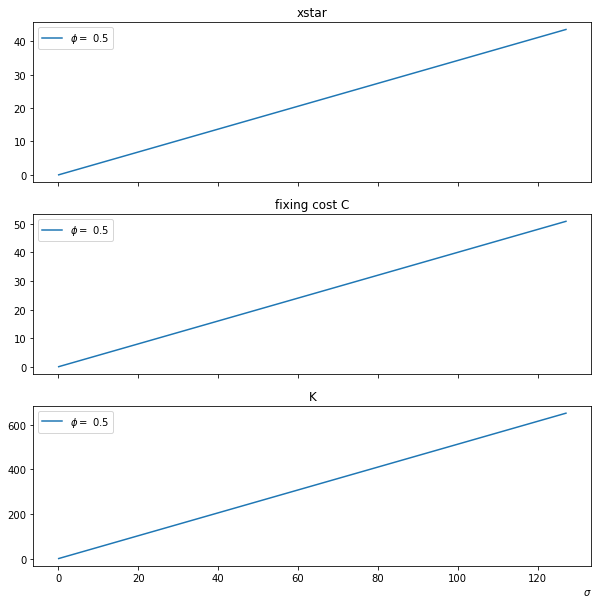

In [394]:
# first sort df in ascending order for sigmas
df_order = df.sort_values('sigma')

fig, axs = plt.subplots(3,1,figsize=(10,10), sharex=True)
axs[0].plot(df_order.sigma, df_order.xstar, label=f'$\phi =$ {phi}')
axs[0].set_title('xstar')
axs[1].plot(df_order.sigma, df_order.fixing_cost, label=f'$\phi =$ {phi}')
axs[1].set_title('fixing cost C')
axs[2].plot(df_order.sigma, df_order.K, label=f'$\phi =$ {phi}')
axs[2].set_title('K')
axs[2].set_xlabel(r'$\sigma$', loc='right')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

## Fine Schedule

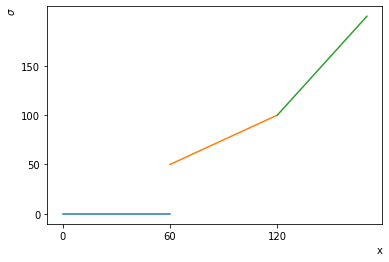

In [395]:
x0, y0 = [0,60], [0,0]
x1, y1 = [60, 120], [50,100]
x2, y2 = [120,170], [100,200]
plt.plot(x0, y0)
plt.plot(x1,y1,x2, y2)
plt.xticks([0,60,120])
plt.yticks([0,50,100,150])
plt.xlabel('x', loc = 'right')
plt.ylabel(r'$\sigma$', loc = 'top')
plt.show()

### Fine schedule tradeoff
$\pi*60 + \frac{\sigma}{\alpha} \pi^{\alpha/(1+\alpha)} \geq (\pi + \phi)^{\alpha/(1+\alpha)} (\sigma + \frac{\sigma}{\alpha})$

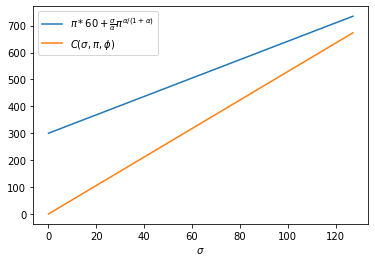

In [396]:
left = [60*pi + s/alpha * pi**(alpha/(1+alpha))  for s in sigma]
right = [(pi + phi)**(alpha/(1+alpha)) * (s + s/alpha) for s in sigma]
tradeoff = pd.DataFrame({'sigma':sigma, 'left':left, 'right':right}).sort_values('sigma')

plt.plot(tradeoff.sigma, tradeoff.left, label = r'$\pi*60 + \frac{\sigma}{\alpha} \pi^{\alpha/(1+\alpha)}$')
plt.plot(tradeoff.sigma, tradeoff.right, label = r'$C(\sigma, \pi, \phi)$')
plt.xlabel(r'$\sigma$')
plt.legend()

solve for $\sigma$ where equality holds

In [397]:
s = symbols('s')
exp = 60*pi + s/alpha * pi**(alpha/(1+alpha)) - (pi + phi)**(alpha/(1+alpha)) * (s + s/alpha)
sigma_bar = solve(exp)
if len(sigma_bar) > 0:
    print('optimal sigma is', f'{sigma_bar[0]:.2f}')
else: print('lines do not intersect')

optimal sigma is 159.95
